WRITE A DESCRIPTION

In [81]:
#! pip install simpy
import simpy
#! pip install numpy
import numpy as np
#! pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
from IPython.display import display

In [82]:
class Scheduler:

    def __init__(self, environment, type):

        self.environment = environment
        self.type = type
        self.vehicles = []
        self.pending_tasks = []
        self.incomplete_tasks= []
        self.completed_tasks = []
        self.task_id_counter = 0
        self.current_task = None
        
        if type == "RANDOM":
            self.environment.process(self.process_randomly(self.environment))
        elif type == "FIFO":
            self.environment.process(self.process_fifo(self.environment))
        elif type == "LIFO":
            self.environment.process(self.process_lifo(self.environment))
        elif type == "EDF":
            self.environment.process(self.process_edf(self.environment))
        else:
            print("Incorrect scheduling type... choose from: RANDOM, FIFO, LIFO or EDF")

    def idle_vehicle_exists(self):
        return any(vehicle.idle for vehicle in self.vehicles)
    
    def pending_task_exists(self):
        return any(vehicle.pending_tasks for vehicle in self.vehicles)
    
    def get_pending_tasks(self):
        return [task for vehicle in self.vehicles for task in vehicle.pending_tasks]
    
    def get_idle_vehicles(self):
        return [vehicle for vehicle in self.vehicles if vehicle.idle]


    def process_randomly(self, environment):
        while True:
            print("time:", environment.now)
            while self.pending_task_exists() and self.idle_vehicle_exists():
                selected_vehicle = random.choice(self.get_idle_vehicles())
                selected_task = random.choice(self.get_pending_tasks())
                print(f"Task {selected_task.id} -> Car {selected_vehicle.id}")

                selected_vehicle.idle = False
                selected_task.vehicle.pending_tasks.remove(selected_task)
                self.environment.process(selected_vehicle.process_task(selected_task))

            yield environment.timeout(1)

    def process_fifo(self, environment):

         while True:
            print("time:", environment.now)
            while self.pending_task_exists() and self.idle_vehicle_exists():
                    selected_vehicle = random.choice(self.get_idle_vehicles())
                    selected_task = min(self.get_pending_tasks(), key=lambda task: task.id)
                    print(f"Task {selected_task.id} -> Car {selected_vehicle.id}")

                    selected_vehicle.idle = False
                    selected_task.vehicle.pending_tasks.remove(selected_task)
                    self.environment.process(selected_vehicle.process_task(selected_task))

            yield environment.timeout(1)

    def process_lifo(self, environment):
        while True:
            print("time:", environment.now)
            while self.pending_task_exists() and self.idle_vehicle_exists():
                    selected_vehicle = random.choice(self.get_idle_vehicles())
                    selected_task = max(self.get_pending_tasks(), key=lambda task: task.id)
                    print(f"Task {selected_task.id} -> Car {selected_vehicle.id}")

                    selected_vehicle.idle = False
                    selected_task.vehicle.pending_tasks.remove(selected_task)

                    self.environment.process(selected_vehicle.process_task(selected_task))

            yield environment.timeout(1)


    def process_edf(self, environment):
        while True:
            print("time:", environment.now)
            while self.pending_task_exists() and self.idle_vehicle_exists():
                    selected_vehicle = random.choice(self.get_idle_vehicles())
                    selected_task = min(self.get_pending_tasks(), key=lambda task: task.priority)
                    print(f"Task {selected_task.id} -> Car {selected_vehicle.id}")

                    selected_vehicle.idle = False
                    selected_task.vehicle.pending_tasks.remove(selected_task)

                    self.environment.process(selected_vehicle.process_task(selected_task))

            yield environment.timeout(1)
            
  #  def process_oracle():

In [83]:
class Task:

    def __init__(self, id, priority, duration, vehicle, environment):

        self.id = id
        self.priority = priority
        self.duration = duration
        self.vehicle = vehicle
        self.environment = environment

        self.time_spent_processing = 0
        self.start = None 
        self.vehicle.assigned_tasks.append(self)
        self.vehicle.pending_tasks.append(self)
        self.vehicle.scheduler.task_id_counter += 1
        self.vehicle.scheduler.pending_tasks.append(self)

    def __str__(self):
        return f"id={self.id}, priority={self.priority}, duration={self.duration}"

In [84]:
class Vehicle:

    def __init__(self, id, environment, lambda_tasks, lambda_dwell_time, scheduler, generator):

        self.id = id
        self.environment = environment
        self.assigned_tasks = []
        self.pending_tasks = []
        self.lambda_tasks = lambda_tasks
        self.lambda_dwell_time = lambda_dwell_time   
        self.scheduler = scheduler
        self.generator = generator
        self.idle = True

        self.completed_tasks = []
        self.inROI = True

        print(f'At t={self.environment.now}, Vehicle {self.id} spawned')
        self.generator.vehicles.append(self)
        self.generator.vehicles_present.append(self)
        self.scheduler.vehicles.append(self)

        #schedule departure
        self.environment.process(self.scheduleDeparture(self.environment))
        #start task generator
        self.environment.process(self.generateTasks())

    def scheduleDeparture(self, environment):
        yield environment.timeout(np.random.poisson(self.lambda_dwell_time))
        self.inROI = False

    def process_task(self, assigned_task):
        print(f"At t={self.environment.now}, Vehicle {self.id} will begin processing Task: {assigned_task}")
        yield self.environment.timeout(assigned_task.duration)
        print(f"AT t={self.environment.now}, Vehicle {self.id} completed Task {assigned_task}")
        self.idle = True
        #vehicle.completed_tasks.append(assigend_task)
        #vehicle.scheudler.completed_tasks.append


    def generateTasks(self):

        while self.inROI:
            yield self.environment.timeout(np.random.poisson(self.lambda_tasks)) 
            new_Task = Task(self.scheduler.task_id_counter, random.randint(0, 5) , random.randint(1, 5) , self, self.environment)
            print(f'At t={self.environment.now}, Vehicle {self.id} generated a new Task {new_Task}')
           
        self.generator.vehicles_present.remove(self)
        self.generator.vehicles_departed.append(self)

        print(f"At t={self.environment.now}, Vehicle {self.id} left the intersection and stopped generating tasks")

In [85]:
class VehicleGenerator:

    def __init__(self, lambda_vehicles, lambda_tasks, lambda_dwell_time, environment, scheduler, generate):

        self.lambda_vehicles = lambda_vehicles
        self.lambda_tasks = lambda_tasks
        self.lambda_dwell_time = lambda_dwell_time
        self.environment = environment
        self.scheduler = scheduler
        self.generate = generate

        self.vehicles = []
        self.vehicles_present = []
        self.vehicles_departed = []

        if self.generate:
            self.environment.process(self.generateVehicles(self.environment))
    
    def tasks_generated(self):
        counter = 0
        for vehicle in self.vehicles:
            counter += len(vehicle.assigned_tasks)
        return counter
    
    def mean_tasks_completed_per_vehicle(self):
        sum = 0
        if len(self.vehicles) == 0: return 0

        for v in self.vehicles:      
            if len(v.assigned_tasks) != 0:
                sum += len(v.completed_tasks)/len(v.assigned_tasks)
            else: 
                sum += 0
        mean = (sum/len(self.vehicles)) * 100
        return mean
    
    def time_spent_processing(self):
        result = []

        for v in self.vehicles:
            v_processing_time = 0
            incomplete_tasks = [t for t in v.assigned_tasks if t not in v.completed_tasks]
            #processing time of all completed tasks
            for t in v.completed_tasks:
                v_processing_time += t.duration
            #processing time of all incomplete tasks
            for t in incomplete_tasks:
                v_processing_time += t.time_spent_processing
            result.append(v_processing_time)    
                
        #should hold the time spent processing for each vehicle   
        return result 
    
    def scheduling_type(self):
        result = []
        for v in self.vehicles:
            result.append(v.scheduler.type)
        return result
        
    def generateVehicles(self, environment):
        while True:
            timeout = np.random.poisson(self.lambda_vehicles)
            yield environment.timeout(timeout)
            Vehicle(len(self.vehicles), environment, self.lambda_tasks, self.lambda_dwell_time, self.scheduler, self)

In [86]:
simulation_data = pd.DataFrame(columns=['scheduling type', 'total vehicles generated',
                                        'vehicles present', 'vehicles departed',
                                        'total tasks generated', 'total tasks completed', 
                                        'total tasks completed percentage', 
                                        'avg. tasks completed per vehicle', 'incomplete tasks',
                                        'vehicle processing times', 'mean vehicle processing times'
                                        ])
exploded_data = None

#run simulation once for each scheduling type
def run_sim(sim_seed, scheduling_type, poisson_vehicles, poisson_tasks, poisson_dwell_time, sim_end_time, generate):

   global simulation_data
   global exploded_data
   index = 0
   
   for type in scheduling_type:

      random.seed(sim_seed)
      np.random.seed(sim_seed)
        
      #run simulation
      intersection = simpy.Environment()
      scheduler = Scheduler(intersection, type)
      vehicle_generator = VehicleGenerator(poisson_vehicles, poisson_tasks, poisson_dwell_time, intersection, scheduler, generate)
      print(f"{'='*50}\nSCHEDULER: {scheduler.type}")
      intersection.run(until = sim_end_time)
      print(f"{'='*50}\n total vehicles spawned: {len(vehicle_generator.vehicles)}\n total tasks generated: {vehicle_generator.tasks_generated()}")

      simulation_data.loc[index] = [type, len(vehicle_generator.vehicles),len(vehicle_generator.vehicles_present),len(vehicle_generator.vehicles_departed), vehicle_generator.tasks_generated(), len(scheduler.completed_tasks), len(scheduler.completed_tasks)/vehicle_generator.tasks_generated() * 100 if vehicle_generator.tasks_generated() != 0 else 0, vehicle_generator.mean_tasks_completed_per_vehicle(), len(scheduler.incomplete_tasks), vehicle_generator.time_spent_processing(), 0 if len(vehicle_generator.vehicles) == 0 else round(sum(vehicle_generator.time_spent_processing())/len(vehicle_generator.vehicles),1)]
      index += 1
      
   #dataframe for swarmplot
   exploded_data = simulation_data.explode('vehicle processing times').reset_index(drop=True)[['scheduling type', 'vehicle processing times']]

In [87]:
run_sim(sim_seed = 42, scheduling_type = ['RANDOM', 'FIFO', 'LIFO', 'EDF'], poisson_vehicles = 3, poisson_tasks = 5, poisson_dwell_time = 15, sim_end_time = 30, generate = True)
display(simulation_data)

SCHEDULER: RANDOM
time: 0
time: 1
time: 2
time: 3
At t=4, Vehicle 0 spawned
time: 4
At t=5, Vehicle 1 spawned
time: 5
At t=6, Vehicle 2 spawned
time: 6
time: 7
At t=8, Vehicle 0 generated a new Task id=0, priority=5, duration=1
At t=8, Vehicle 2 generated a new Task id=1, priority=0, duration=3
time: 8
Task 0 -> Car 0
Task 1 -> Car 1
At t=8, Vehicle 0 will begin processing Task: id=0, priority=5, duration=1
At t=8, Vehicle 1 will begin processing Task: id=1, priority=0, duration=3
At t=9, Vehicle 1 generated a new Task id=2, priority=5, duration=5
At t=9, Vehicle 3 spawned
time: 9
Task 2 -> Car 2
At t=9, Vehicle 2 will begin processing Task: id=2, priority=5, duration=5
AT t=9, Vehicle 0 completed Task id=0, priority=5, duration=1
time: 10
AT t=11, Vehicle 1 completed Task id=1, priority=0, duration=3
time: 11
At t=12, Vehicle 2 generated a new Task id=3, priority=0, duration=1
time: 12
Task 3 -> Car 0
At t=12, Vehicle 0 will begin processing Task: id=3, priority=0, duration=1
At t=13,

,scheduling type,total vehicles generated,vehicles present,vehicles departed,total tasks generated,total tasks completed,total tasks completed percentage,avg. tasks completed per vehicle,incomplete tasks,vehicle processing times,mean vehicle processing times
0,RANDOM,9,5,4,24,0,0.0,0.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
1,FIFO,9,5,4,24,0,0.0,0.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
2,LIFO,9,5,4,24,0,0.0,0.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
3,EDF,9,5,4,24,0,0.0,0.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0


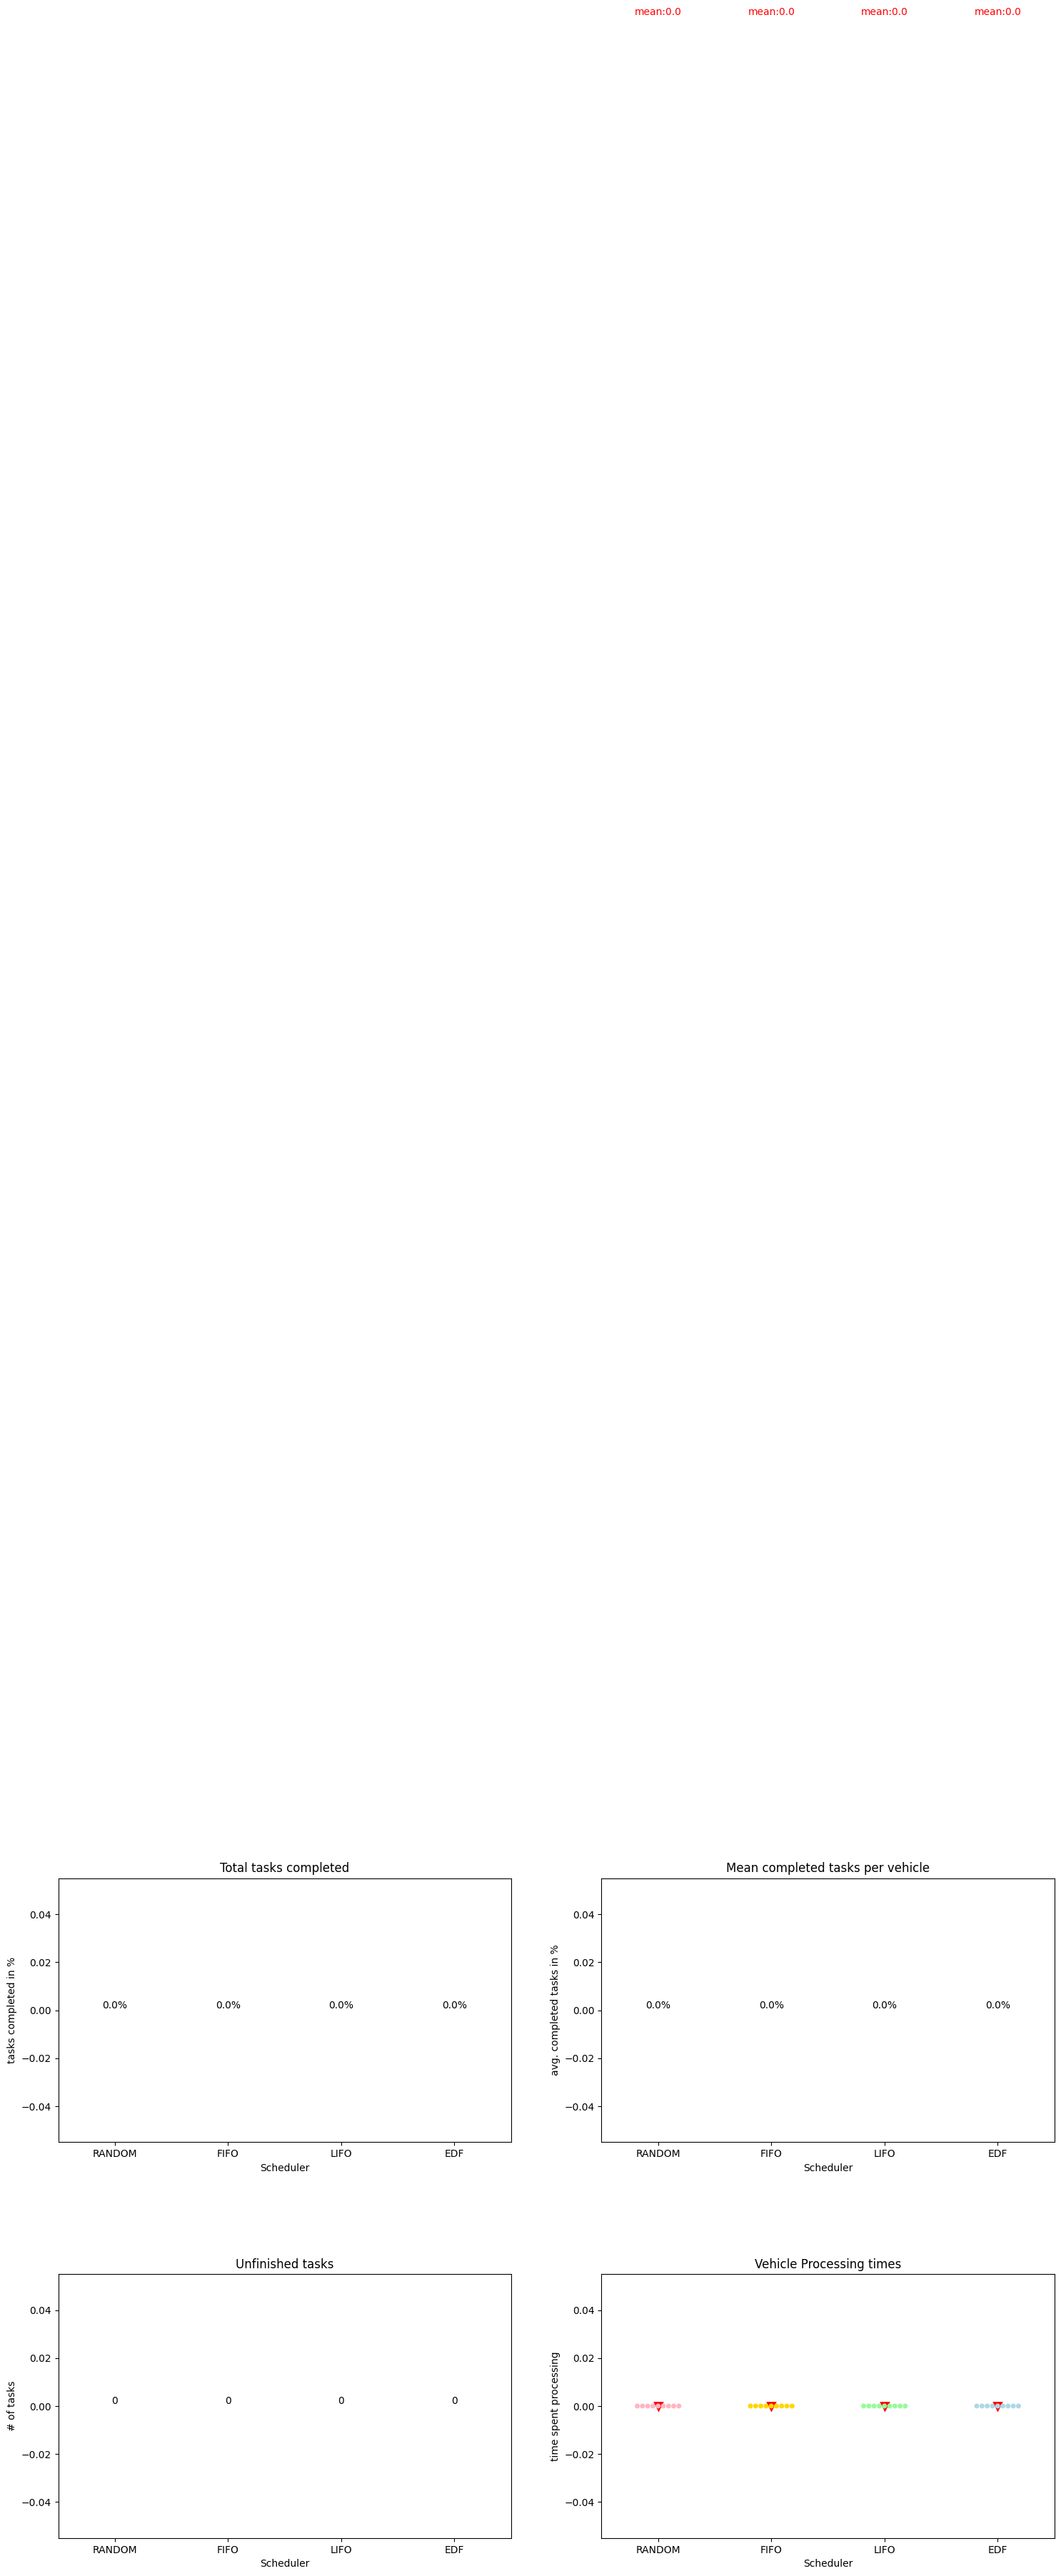

In [88]:
scheduling_type = ['RANDOM', 'FIFO', 'LIFO', 'EDF']

pastel_colors = ['#FFB6C1', '#FFD700', '#98FB98', '#ADD8E6']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.5)


# Plot 1
sns.barplot(x=scheduling_type, y=simulation_data['total tasks completed percentage'], ax=axes[0, 0], hue= scheduling_type, palette=pastel_colors)
axes[0, 0].set_title('Total tasks completed')
axes[0, 0].set_xlabel('Scheduler')
axes[0, 0].set_ylabel('tasks completed in %')

# Plot 2
sns.barplot(x=scheduling_type, y=simulation_data['avg. tasks completed per vehicle'], ax=axes[0, 1], hue= scheduling_type, palette=pastel_colors)
axes[0, 1].set_title('Mean completed tasks per vehicle')
axes[0, 1].set_xlabel('Scheduler')
axes[0, 1].set_ylabel('avg. completed tasks in %')

# Plot 3
sns.barplot(x=scheduling_type, y=simulation_data['incomplete tasks'], ax=axes[1, 0], hue= scheduling_type, palette=pastel_colors)
axes[1, 0].set_title('Unfinished tasks')
axes[1, 0].set_xlabel('Scheduler')
axes[1, 0].set_ylabel('# of tasks')

# plot 4
sns.swarmplot(data=exploded_data, x='scheduling type', y='vehicle processing times', ax=axes[1, 1], hue= exploded_data['scheduling type'], palette=pastel_colors)
axes[1,1].set_title('Vehicle Processing times')
axes[1,1].set_xlabel('Scheduler')
axes[1,1].set_ylabel('time spent processing')

#labeling the plots
for index, value in enumerate(simulation_data['total tasks completed percentage']):
    axes[0, 0].text(index, value, f"{round(value,1)}%", ha='center', va='bottom')

for index, value in enumerate(simulation_data['avg. tasks completed per vehicle']):
    axes[0, 1].text(index, value,f"{round(value,1)}%", ha='center', va='bottom')

for index, value in enumerate(simulation_data['incomplete tasks']):
    axes[1, 0].text(index, value, str(value), ha='center', va='bottom')

sns.pointplot(data= simulation_data, x='scheduling type', y='mean vehicle processing times', color='red', markers='v', linestyle='none')

for i, row in simulation_data.iterrows():
    plt.text(i, row['mean vehicle processing times'] + 1, f'mean:{row["mean vehicle processing times"]:.1f}', color='red', ha="center", va = "top")

plt.show()